# Google DeepDream Implementation

Name: Anthony Kevin Oktavius

Code References:

* https://github.com/anaramirli/visualizing-cnn-features

* https://github.com/fg91/visualizing-cnn-feature-maps/blob/master/filter_visualizer.ipynb

* https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [ ]:
! pip install git+https://github.com/tensorflow/docs
! pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ex96dh_n
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ex96dh_n
  Resolved https://github.com/tensorflow/docs to commit 3ad57a2dd8c8878c47e6e7e7cdfbe43d3c528d34
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183273 sha256=9f1a5c78b35479f9edc83acefa4e897cb7833be4976b167c1bbf423b0f04c07b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kdnx1r58/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import h5py
import zipfile
import cv2
import shutil
import zipfile
import os
import imageio
import zipfile
import gc
import copy
import math
import warnings
import random
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import tensorflow_docs.vis.embed as embed
import xml.etree.ElementTree as ET # Parse XML Data.

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
# from scipy import ndimage
# from PIL import Image
from torch.utils.data import Dataset
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Modelling

In [ ]:
class MNISTModel(nn.Module):
  def __init__(self):
    super().__init__()

    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1, bias = True), 
        nn.ReLU(), 
        nn.MaxPool2d(2,2))

    # To attain same padding: we use features of 
    # Padding: [(3 - 1) / 2] = 1
    # Output after conv2: [(14 - 3 + 2 (1) / 1) + 1] = 14
    # Output after MaxPool2: 14 / 2 = 7
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, bias = True), 
      nn.ReLU(), 
      nn.MaxPool2d(2,2)
    )

    self.avg_pool2d = nn.AdaptiveAvgPool2d(output_size = (3, 3))

    # Flatten the layers.
    # 32 = number of filters
    # 7 = size of max pool 2 feature map output.
    self.fc1 = nn.Sequential(
      nn.Flatten(), 
      nn.Linear(64*3*3,32), 
      nn.ReLU(), 
      nn.Linear(32,16),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(16,8), 
      nn.ReLU(),
      nn.Linear(8,10)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.avg_pool2d(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

mnist_model = MNISTModel().to(device)
mnist_model

MNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool2d): AdaptiveAvgPool2d(output_size=(3, 3))
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
mnist_model = MNISTModel().to(device)

optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

Using VGG16 Model in our model.

In [ ]:
def load_model(model, optimizer, filename = "model.pth.tar"):
  print("Loading model...")
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Finished loading model!")

  return model, optimizer

directory_path = "./drive/MyDrive/Models"
mnist_model = MNISTModel().to(device)
mnist_model.eval()
mnist_model, optimizer = load_model(mnist_model, optimizer, f"{directory_path}/ocr_mnist_model.pth.tar")

Loading model...
Finished loading model!


## Deep Dream Implementation using Pretrained Model.

Define hook for getting the output of a specific layer.

In [ ]:
class BasicHook():
  """
  Get All of Layers Outputs, mainly for Visualization.
  """
  def __init__(self, layer_name, layer):
    self.layer_name = layer_name
    self.layer = layer
    self.latest_output = None

    layer.register_forward_hook(self.forward_hook_fn)

  def forward_hook_fn(self, layer, input, output):
    self.latest_output = output

  def close(self):
    self.hook.remove()

conv3_hook = None

# Get conv3 layer.
for layer_name, layer in mnist_model.named_modules():

  if layer_name == "fc2":
    conv3_hook = BasicHook(layer_name, layer)
    print("Found layer!")

print(conv3_hook.layer)
print(conv3_hook.layer_name)

Found layer!
Sequential(
  (0): Linear(in_features=16, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=10, bias=True)
)
fc2


Image is taken from: https://www.google.com/url?sa=i&url=https%3A%2F%2Funsplash.com%2Fs%2Fphotos%2Fhigh-resolution&psig=AOvVaw08nObHDne2NkvvxALsV2Em&ust=1682524670023000&source=images&cd=vfe&ved=0CBEQjRxqFwoTCOCtqsazxf4CFQAAAAAdAAAAABAE

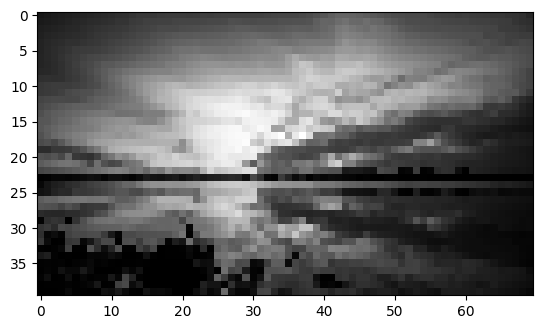

In [15]:
def load_image(image_path, resized_size = (50, 50)):
  loaded_image = cv2.imread(image_path)
  loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2GRAY)
  loaded_image = cv2.resize(loaded_image, resized_size)
  # preprocessed_image = preprocess_image(loaded_image)
  return loaded_image

def visualize_pytorch_images_in_batch(images_in_batch):
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  print(plt_compatible_grid_images_in_batch.shape)
  plt.imshow(plt_compatible_grid_images_in_batch)

ORIGINAL_WIDTH = 70
ORIGINAL_HEIGHT = 40

loaded_image = load_image(
  "./drive/MyDrive/Dataset/Neural Style Transfer/Foto Pemandangan Alam.jpg",
  resized_size = (ORIGINAL_WIDTH, ORIGINAL_HEIGHT)
)
plt.imshow(loaded_image, cmap = "gray")
# visualize_pytorch_images_in_batch(loaded_image)

In [97]:
def convert_frames_to_gif(frames, gif_name = "sample.gif"):
  frames = np.array(frames, dtype = np.uint8)
  # print(converted_frames)
  imageio.mimsave(gif_name, frames, fps = 10)
  return embed.embed_file(gif_name)

def preview_gif(filename):
  from IPython.display import Image, display
  gif_file = Image(filename = filename)
  display(gif_file)

def make_deep_dream(model, hook, input_image, filter_indexes, 
                    upscaling_factor = 1.1, upscaling_steps = 15, num_iterations = 200,
                    learning_rate = 0.01):
  original_input_image = input_image.copy()
  current_input_image = original_input_image
  current_input_image = np.expand_dims(current_input_image, axis = 2)

  for upscale_iteration in range(upscaling_steps):
    tensor_input_image = np.transpose(current_input_image, (2, 1, 0))
    tensor_input_image = torch.Tensor(
        tensor_input_image
    ).to(device)
    tensor_input_image = tensor_input_image.unsqueeze(0)
    tensor_input_image.requires_grad = True
    deep_dream_optimizer = optim.SGD([tensor_input_image], lr = learning_rate)

    print("=" * 50, f"Current Iteration: {upscale_iteration}")
    for model_iteration in range(num_iterations):

      optimizer.zero_grad()
      # Feed forward the model.
      model(tensor_input_image)
      tensor_output_images = hook.latest_output[:, filter_indexes]

      # Perform Gradient Ascent.
      loss = -(tensor_output_images).mean()

      print(f"Current iteration: {model_iteration} / {num_iterations}, loss is: {loss.item()}")

      loss.backward()
      deep_dream_optimizer.step()

    # Resize the image, so we can make less granularity on the image with deep dream applied.
    flattened_tensor_image = tensor_input_image.squeeze(0)
    flattened_tensor_image = flattened_tensor_image.permute(2, 1, 0).cpu().detach().numpy()

    current_width_size = flattened_tensor_image.shape[1]
    current_height_size = flattened_tensor_image.shape[0]
    new_width_size = int(current_width_size * upscaling_factor)
    new_height_size = int(current_height_size * upscaling_factor)
    current_input_image = cv2.resize(
      flattened_tensor_image, (new_width_size, new_height_size), 
      interpolation = cv2.INTER_CUBIC
    )
    current_input_image = np.expand_dims(current_input_image, axis = 2)
    print("=" * 50)

  return current_input_image

class_indexes = range(0, 10)
result_images = []
for class_index in class_indexes:
  result_image = make_deep_dream(
    mnist_model, 
    conv3_hook, 
    loaded_image, 
    filter_indexes = [class_index], 
  )

  result_images.append(result_image)

print("Image Debugging:")
print(len(result_images))

Streaming output truncated to the last 5000 lines.
Current iteration: 51 / 200, loss is: -89.95254516601562
Current iteration: 52 / 200, loss is: -90.22378540039062
Current iteration: 53 / 200, loss is: -90.499755859375
Current iteration: 54 / 200, loss is: -90.77838134765625
Current iteration: 55 / 200, loss is: -91.06161499023438
Current iteration: 56 / 200, loss is: -91.34970092773438
Current iteration: 57 / 200, loss is: -91.642822265625
Current iteration: 58 / 200, loss is: -91.94094848632812
Current iteration: 59 / 200, loss is: -92.2440185546875
Current iteration: 60 / 200, loss is: -92.55209350585938
Current iteration: 61 / 200, loss is: -92.86532592773438
Current iteration: 62 / 200, loss is: -93.18368530273438
Current iteration: 63 / 200, loss is: -93.5069580078125
Current iteration: 64 / 200, loss is: -93.83541870117188
Current iteration: 65 / 200, loss is: -94.16909790039062
Current iteration: 66 / 200, loss is: -94.50814819335938
Current iteration: 67 / 200, loss is: -94.8

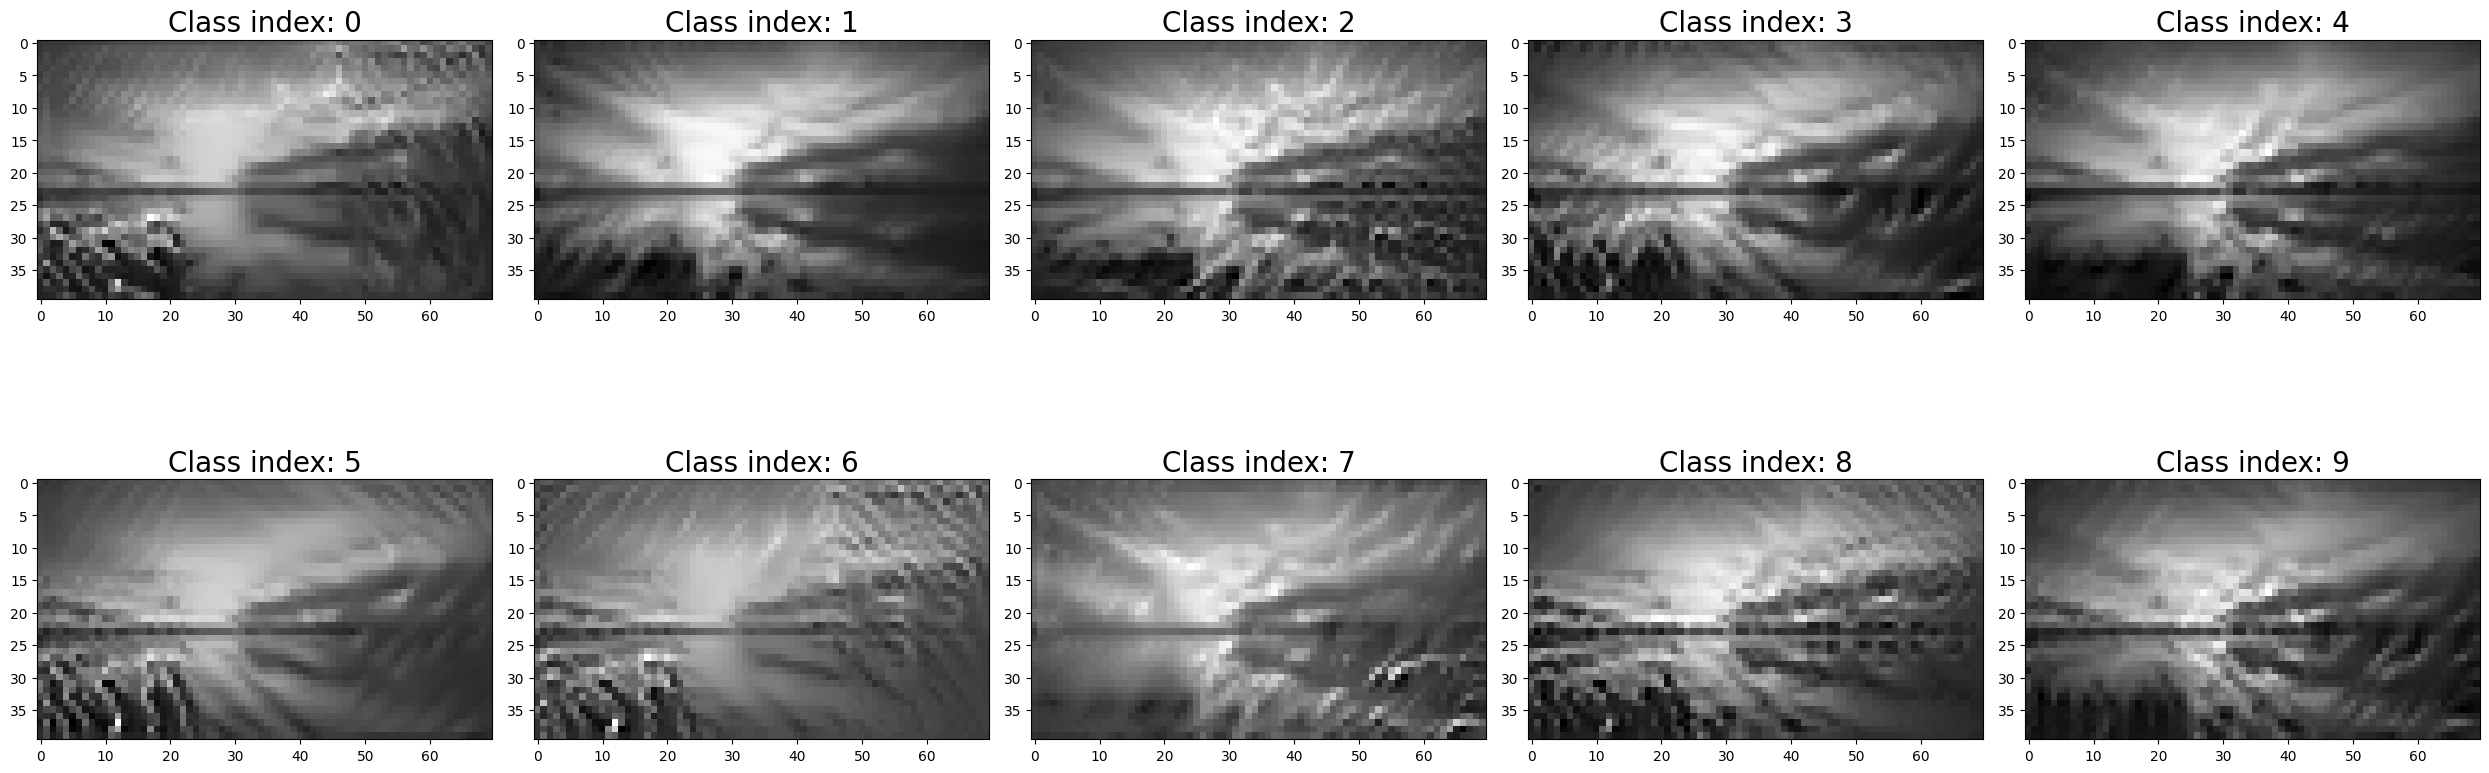

In [102]:
N_ROWS = 2
N_COLS = 5
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (25, 10))

for class_index in class_indexes:
  row_index = int(class_index / N_COLS)
  col_index = class_index % N_COLS
  resized_image = cv2.resize(result_images[class_index], (ORIGINAL_WIDTH, ORIGINAL_HEIGHT))
  axes[row_index][col_index].imshow(resized_image, cmap = "gray")
  axes[row_index][col_index].set_title(f"Class index: {class_index}", fontsize=20)

plt.tight_layout()
plt.show()

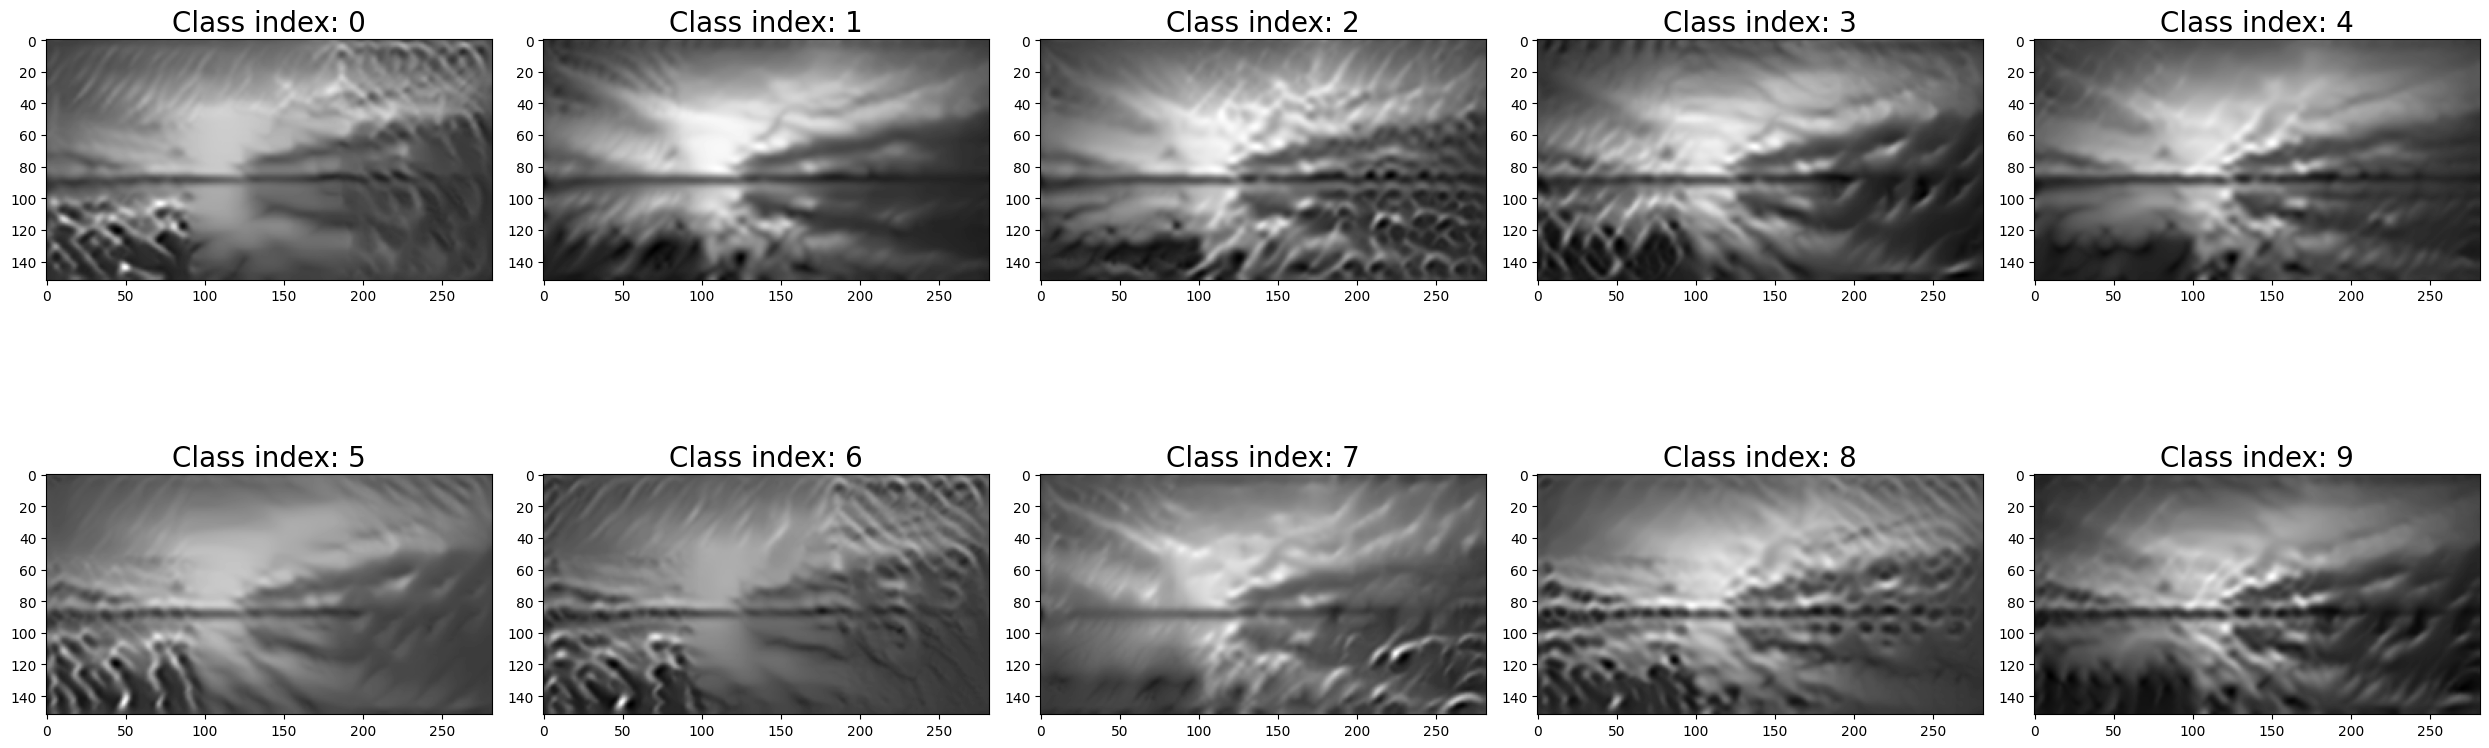

In [104]:
N_ROWS = 2
N_COLS = 5
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (25, 10))

for class_index in class_indexes:
  row_index = int(class_index / N_COLS)
  col_index = class_index % N_COLS
  axes[row_index][col_index].imshow(result_images[class_index], cmap = "gray")
  axes[row_index][col_index].set_title(f"Class index: {class_index}", fontsize=20)

plt.tight_layout()
plt.show()